# Detekce anomálií v datech o znečištění ovzduší

TODO list:

- napsat úvodu,
- napsat detailní Jupyter notebook (části, které se počítají dlouho přenést do scriptů,
    např. načítat externě natrénované LSTM).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


from lampy import data
from lampy import metrics
from lampy.lstm import LSTM

## Explorace

TODO list:

- vizualizace: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html.

DONE list:

- podívat se, co má více data, jestli je to PM<sub>2.5</sub> nebo PM<sub>10</sub>: stejně.

### Datové zdroje

V [katalogu datové platformy Golemio](https://golemio.cz/cs/node/622) jsou k dispozici dva datové soubory:
jeden za druhé pololetí roku 2018 a druhý za zatím uplynulou část prvního pololetí roku 2019.

In [2]:
data_file_2018 = 'data/636f6a2e-3a48-4801-afce-05c864adc60e-lampy_2019.csv'
data_2018 = pd.read_csv(data_file_2018, index_col='sid', sep=';', parse_dates=['starttimestamp'])
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473529 entries, 24a5mhj5yiqqhmtxzvsztbwxoduhdzyd to y7e4onsytkb3ydonflz5kcbcigkh5ulo
Data columns (total 8 columns):
starttimestamp              473529 non-null datetime64[ns, UTC]
geocoordinates_latitude     473505 non-null float64
geocoordinates_longitude    473505 non-null float64
o3                          407537 non-null float64
pm2p5                       129807 non-null float64
no2                         407537 non-null float64
so2                         407537 non-null float64
pm10                        129807 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 32.5+ MB


In [3]:
data_file_2019 = 'data/2e6bbd16-8d1c-4efa-b0f0-06a74f40d8d3-lampysensory-2019-1pololeti.csv'
data_2019 = pd.read_csv(data_file_2019, index_col='sid', parse_dates=['starttimestamp'])
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226672 entries, 6aivodbkkk3xlwbjlkerclrnk4gtfy3x to oowrrh4zfxs66zdreivyrri2ribhexgc
Data columns (total 8 columns):
starttimestamp              226672 non-null datetime64[ns, UTC]
geocoordinates_latitude     226672 non-null float64
geocoordinates_longitude    226672 non-null float64
o3                          196871 non-null float64
pm2p5                       62518 non-null float64
no2                         196871 non-null float64
so2                         196871 non-null float64
pm10                        62518 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 15.6+ MB


### Sloupce

Datová sada by měla obsahovat odečty z 43 senzorů, které jsou rozmístěny na vybraných lampách.

- `sid` (string): identifikátor stanice;
- `starttimestamp` (datetime): datum a čas měření,
- `o3` (integer with precision): atribut O<sub>3</sub> (ozon, ppb),
- `no2` (integer with precision): atribut NO<sub>2</sub> (oxid dusičitý, ppb),
- `so2` (integer with precision): atribut SO<sub>2</sub> (oxid siřičitý, ppb),
- `pm10` (integer with precision): atribut jemné částice PM<sub>10</sub> (µg m<sup>-3</sup>),
- `pm2p5` (integer with precision): atribut jemné částice PM<sub>2,5</sub> (µg m<sup>-3</sup>),
- `geocoordinates_latitude` (integer with precision): zeměpisná šířka stanice,
- `geocoordinates_longitude` (integer with precision): zeměpisná délka stanice,

kde ppb znamená [parts per bilion](https://en.wikipedia.org/wiki/Parts-per_notation).

In [4]:
sids = data_2018.index.unique()
print('počet sensorů:', len(sids))

počet sensorů: 22


In [5]:
target = 'pm10'
value_counts = data_2018[target].dropna().index.value_counts()
value_counts

y7e4onsytkb3ydonflz5kcbcigkh5ulo    32872
heql54pdiq6xb6j74qdpnlovm77jaify    24548
6czebgzn24hwd3vpklvuphomcfcwpqgx    24100
xct4lqv4q3ht3a7peubhfnyyhbsnno7g    17447
bxjhuifodo6nf7bnstd55g3mzw6wfv7c    17078
gdyaoaed7gnarg6kqk2o6bmsjrw6wlk5    13762
Name: sid, dtype: int64

In [6]:
sid = value_counts.index[0]
sid

'y7e4onsytkb3ydonflz5kcbcigkh5ulo'

### Trénovací a testovací data

In [7]:
features = ['o3', 'pm2p5', 'no2', 'so2', 'pm10']

In [8]:
train_data = data_2018.loc[sid].set_index('starttimestamp')[features].sort_index()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32872 entries, 2018-07-05 11:52:18+00:00 to 2018-12-31 23:53:11+00:00
Data columns (total 5 columns):
o3       32872 non-null float64
pm2p5    32872 non-null float64
no2      32872 non-null float64
so2      32872 non-null float64
pm10     32872 non-null float64
dtypes: float64(5)
memory usage: 1.5 MB


In [9]:
test_data = data_2019.loc[sid].set_index('starttimestamp')[features].sort_index()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12709 entries, 2019-01-01 00:03:11+00:00 to 2019-04-04 15:23:07+00:00
Data columns (total 5 columns):
o3       12709 non-null float64
pm2p5    12709 non-null float64
no2      12709 non-null float64
so2      12709 non-null float64
pm10     12709 non-null float64
dtypes: float64(5)
memory usage: 595.7 KB


In [10]:
n_train = data_2018.shape[0]
n_test = data_2019.shape[0]
n_data = n_train + n_test
print('celkem záznamů:', n_data)
print('trénovacích záznamů: {} ({:.1f}%)'.format(n_train, 100 * n_train / n_data))
print('testovacích záznamů: {} ({:.1f}%)'.format(n_test, 100 * n_test / n_data))

celkem záznamů: 700201
trénovacích záznamů: 473529 (67.6%)
testovacích záznamů: 226672 (32.4%)


### Vizualizace

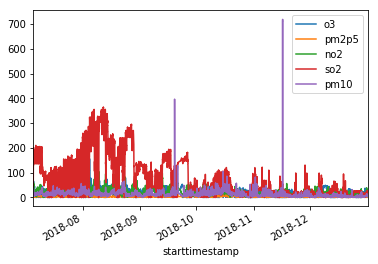

In [11]:
train_data.plot()

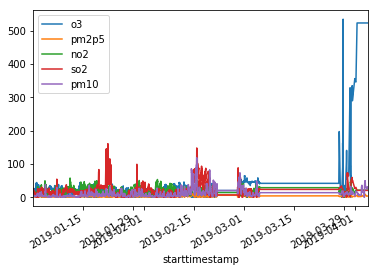

In [12]:
test_data.plot()

### Rozdíl časů odečtů

Vyčítací frekvence 15 minut z brány do platformy, čtení na bráně častější.

In [13]:
time_delta = pd.Series(train_data.index[1:] - train_data.index[:-1])
time_delta_mean = time_delta.mean()
time_delta_std = time_delta.std()
time_delta_mean, time_delta_std

(Timedelta('0 days 00:07:51.809588'), Timedelta('0 days 00:18:20.667901'))

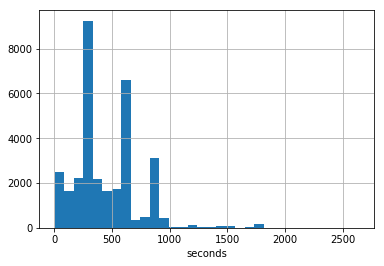

In [14]:
ax = time_delta[time_delta < time_delta_mean + 2 * time_delta_std].dt.total_seconds().hist(bins=32)
ax.set_xlabel('seconds');

### Log–log plot

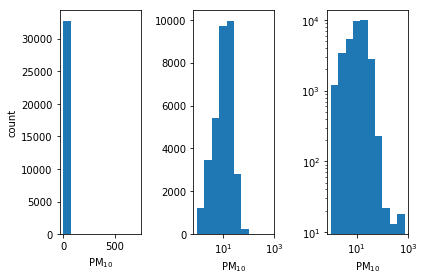

In [15]:
pm10 = train_data['pm10'].values
fig, axs = plt.subplots(ncols=3)
axs[0].hist(pm10)
bins = np.logspace(np.log10(pm10.min()), np.log10(pm10.max()), num=11)
axs[1].hist(pm10, bins)
axs[1].set_xscale('log')
axs[2].hist(pm10, bins, log=True)
axs[2].set_xscale('log')
axs[0].set_ylabel('count')
for ax in axs:
    ax.set_xlabel('$\mathrm{PM}_{10}$')
fig.tight_layout()

## Předzpracování

TODO list:

- jak a proč jsem předzpracovávál data?

In [16]:
resampled_train_data = data.resample_data(train_data, period='15T')
X, y = data.create_dataset(resampled_train_data)

X_tr_raw, X_val_raw, y_tr_raw, y_val_raw = data.train_validation_split(X, y)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_tr = X_scaler.fit_transform(X_tr_raw)
y_tr = y_scaler.fit_transform(y_tr_raw)

X_val = X_scaler.transform(X_val_raw)
y_val = y_scaler.transform(y_val_raw)

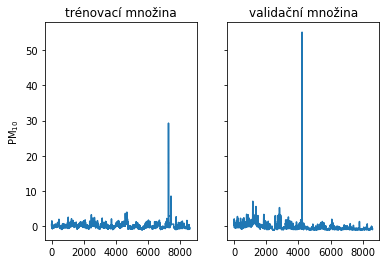

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(y_tr)
ax1.set_ylabel('$\mathrm{PM}_{10}$')
ax1.set_title('trénovací množina')
ax2.plot(y_val)
ax2.set_title('validační množina');

## Selekce příznaků

TODO list:

- pomocí LASSO lineární regrese ukázat, že stačí pouze zvolený příznak.

,RMSE,koeficient o3,koeficient pm2p5,koeficient no2,koeficient so2,koeficient pm10
alpha,,,,,,
1.000000e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-07,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-07,0.638710,-0.016697,0.001962,0.019412,0.011029,0.947370
1.000000e-06,0.638710,-0.016697,0.001963,0.019412,0.011028,0.947369


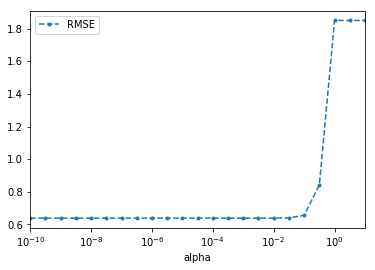

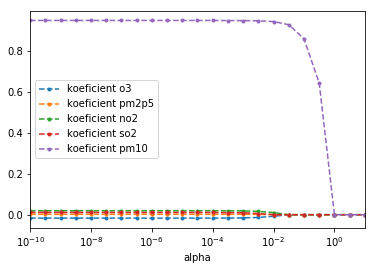

In [18]:
n_features = X_tr.shape[1]
columns = ['RMSE'] + ['koeficient ' + feature for feature in features]

n_alphas = 23
alphas = np.logspace(-10, 1, n_alphas)
lasso_stats = pd.DataFrame(index=alphas, columns=columns, dtype=np.float)
lasso_stats.index.name = 'alpha'

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_tr, y_tr)

    y_pred = lasso.predict(X_val)
    
    lasso_rmse = metrics.rmse(y_val, y_pred)
    lasso_stats.loc[alpha] = (lasso_rmse, *lasso.coef_)

lasso_stats.plot(y='RMSE', logx=True, style='.--');
lasso_stats.plot(y=columns[1:], logx=True, style='.--')
lasso_stats

## Porovnání modelů

TODO list:

- na validačním setu vybrat jeden z modelů pouze podle RMSE:
    1. baseline,
    2. lineární regrese,
    3. lasso,
    4. LSTM.

### Základní model (baseline)

In [19]:
target_index = np.where(train_data.columns == 'pm10')[0][0]
y_pred = X_val[:, target_index]
baseline_rmse = metrics.rmse(y_val, y_pred)
print('RMSE základního modelu:', baseline_rmse)

RMSE základního modelu: 0.6492021924513821


### Linearní regrese

In [20]:
linear_predictor = linear_model.LinearRegression()
linear_predictor.fit(X_tr, y_tr)

y_pred = linear_predictor.predict(X_val)

linear_rmse = metrics.rmse(y_val, y_pred)
print('RMSE lineární regrese:', linear_rmse)

RMSE lineární regrese: 0.6387100615927432


,RMSE
okno,
2,0.636928


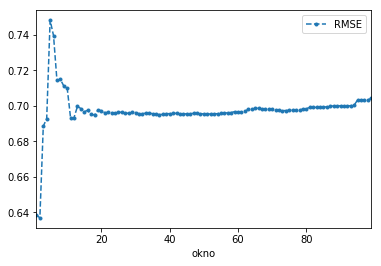

In [21]:
windows = list(range(1, 100))
linear_stats = pd.DataFrame(index=windows, columns=['RMSE'],
                            dtype=np.float)
linear_stats.index.name = 'okno'

for window in windows:
    X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, window)
    X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, window)

    linear = linear_model.LinearRegression()
    linear.fit(X_tr_trans, y_tr_trans)

    y_pred = linear.predict(X_val_trans)
    linear_stats.loc[window] = metrics.rmse(y_val_trans, y_pred)

linear_stats.plot(style='.--')
best_window = linear_stats['RMSE'].idxmin()
best_linear_rmse = linear_stats.loc[best_window, 'RMSE']
linear_stats.loc[[best_window]]

### Long Short-Term Memory (LSTM) rekurentní neuronová síť

epoch: 1 train loss: 0.678628551641731 validation loss: 2.4912716892989786
epoch: 2 train loss: 0.5341636928409182 validation loss: 2.3516048902477946
epoch: 3 train loss: 0.4500276121232514 validation loss: 2.2387874394295495
epoch: 4 train loss: 0.39011416156461126 validation loss: 2.1511876523328692
epoch: 5 train loss: 0.34687958854978695 validation loss: 2.0797927275562906
epoch: 6 train loss: 0.3152383425297325 validation loss: 2.0069819231662023
epoch: 7 train loss: 0.29030466186778875 validation loss: 1.9535255538387883
epoch: 8 train loss: 0.27176783632484897 validation loss: 1.8961627078255572
epoch: 9 train loss: 0.2543188763245101 validation loss: 1.8485277436237812
epoch: 10 train loss: 0.2411363432617362 validation loss: 1.7998036674138231
epoch: 11 train loss: 0.22681213668609732 validation loss: 1.756276363560527
epoch: 12 train loss: 0.21497339044356512 validation loss: 1.7250591196610956
epoch: 13 train loss: 0.20667529071200677 validation loss: 1.6740926673485377
epo

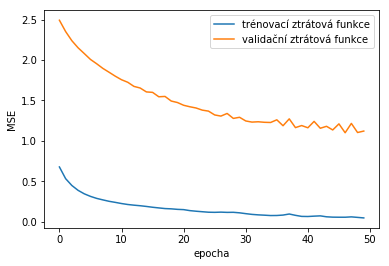

In [22]:
lstm = LSTM(input_size=5, hidden_size=64, output_size=1)
lstm_stats = lstm.train(X_tr, y_tr, X_val, y_val,
                        n_epochs=50, seq_len=100)

ax = plt.axes()
ax.plot(lstm_stats['tr_losses'], label='trénovací ztrátová funkce')
ax.plot(lstm_stats['val_losses'], label='validační ztrátová funkce')
ax.set_xlabel('epocha')
ax.set_ylabel('MSE')
ax.legend()

y_pred = lstm.predict(X_val)
lstm_rmse = metrics.rmse(y_val, y_pred)
print('RMSE LSTM:', lstm_rmse)

### Výsledky

In [23]:
print('RMSE základního modelu:', baseline_rmse)
print('RMSE lineární regrese:', linear_rmse)
print('RMSE lineární regrese s oknem:', best_linear_rmse)
print('RMSE LSTM:', lstm_rmse)

RMSE základního modelu: 0.6492021924513821
RMSE lineární regrese: 0.6387100615927432
RMSE lineární regrese s oknem: 0.6369284611190263
RMSE LSTM: 1.0593174708443691


## Detekce anomálií

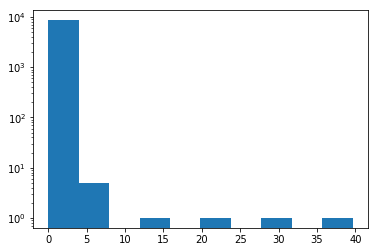

In [24]:
linear = linear_model.LinearRegression()
X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, best_window)
X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, best_window)
linear.fit(X_tr_trans, y_tr_trans)

y_pred = linear.predict(X_val_trans)
y_delta = np.abs(y_val_trans - y_pred)

ax = plt.axes()
bins = np.logspace(np.log10(y_delta.min()), np.log10(y_delta.max()), num=11)
_, bins, _ = ax.hist(y_delta)
ax.set_yscale('log')

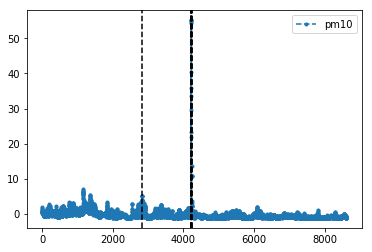

In [25]:
threshold = bins[1]
anomalies = y_delta > threshold

plt.plot(y_val_trans, '.--', label='pm10')

for anomaly in np.arange(anomalies.shape[0])[anomalies.ravel()]:
    plt.axvline(anomaly, ls='--', color='k')
plt.legend();

## Testování

TODO list:

- testování vybraného modelu na testovacím setu hlavně z hlediska detekovaných anomálií.

## Závěr